In [2]:
#Imports
import numpy as np
import pandas as pd
import tensorflow.keras.backend as k
from sklearn.preprocessing import MinMaxScaler,  RobustScaler
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, losses, regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber



In [3]:
import numpy as np
import pandas as pd

# Read a specific sheet
df = pd.read_excel(r"MayniladDataSet.xlsx",
                   sheet_name='04-VAL04H-PM-1 MIRANDA-PSAN_Pre')

df.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,PMP,04-VAL04H-PM-1 MIRANDA-PSAN_Pressure,DATETIME,PSI
6,NaN,NaN,2022-01-01 00:00:00,[-11057] Not Enough Values For Calculation
7,NaN,NaN,2022-01-01 00:15:00,[-11057] Not Enough Values For Calculation
8,NaN,NaN,2022-01-01 00:30:00,[-11057] Not Enough Values For Calculation
9,NaN,NaN,2022-01-01 00:45:00,[-11057] Not Enough Values For Calculation


In [4]:
# Don't use this unless you're gonna change your prv dataset.
# to clean

df.drop(['Unnamed: 1', 'Unnamed: 0'], axis=1, inplace=True)
df.to_csv('Dataset.csv', index=False)
df.head(100)

,Unnamed: 2,Unnamed: 3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,2022-01-01 22:15:00,[-11057] Not Enough Values For Calculation
96,2022-01-01 22:30:00,[-11057] Not Enough Values For Calculation
97,2022-01-01 22:45:00,[-11057] Not Enough Values For Calculation
98,2022-01-01 23:00:00,[-11057] Not Enough Values For Calculation


In [5]:
import numpy as np
import pandas as pd
#Cleaning changing Not enough values to NaN
df3 = pd.read_csv("Dataset.csv", skiprows=6)
df3.columns = ['DATETIME', 'PSI']
df3.replace('[-11057] Not Enough Values For Calculation', np.nan, inplace=True)
#changing data types

df3['PSI'] = pd.to_numeric(df3['PSI'], errors='coerce')
df3['DATETIME'] = pd.to_datetime(df3['DATETIME'], errors='coerce')
df3.dtypes
df3

,DATETIME,PSI
0,2022-01-01 00:00:00,NaN
1,2022-01-01 00:15:00,NaN
2,2022-01-01 00:30:00,NaN
3,2022-01-01 00:45:00,NaN
4,2022-01-01 01:00:00,NaN
...,...,...
101659,2024-11-24 22:45:00,7.81
101660,2024-11-24 23:00:00,9.23
101661,2024-11-24 23:15:00,9.94
101662,2024-11-24 23:30:00,8.52


In [6]:
# Creates a separate copy
df_new = df3.copy()  
# Set the index to the 'DATETIME' column
df_new.index = df_new['DATETIME'] 
df_new.drop('DATETIME', axis=1, inplace=True)

df_new




,PSI
DATETIME,
2022-01-01 00:00:00,NaN
2022-01-01 00:15:00,NaN
2022-01-01 00:30:00,NaN
2022-01-01 00:45:00,NaN
2022-01-01 01:00:00,NaN
...,...
2024-11-24 22:45:00,7.81
2024-11-24 23:00:00,9.23
2024-11-24 23:15:00,9.94


In [7]:
#df_new.loc[df_new['PSI'] > 30, 'PSI'] = np.nan
df_new['PSI'] = df_new['PSI'].interpolate(method='time')
df_new['PSI'] = df_new['PSI'].rolling(window=5, center=True).median()

In [8]:
df_new.fillna(0, inplace=True)

df_new

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


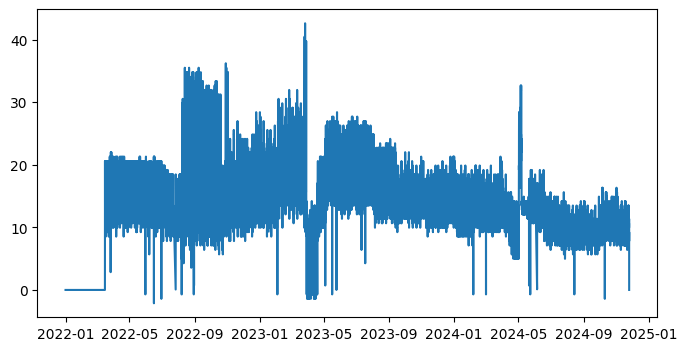

In [9]:
#visualizing my dataframe
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

# Plot using numerical indices on the x-axis
plt.plot(df_new.index, df_new['PSI'], label='PSI')
# Formatting




In [10]:
df_new['PSI']




DATETIME
2022-01-01 00:00:00    0.00
2022-01-01 00:15:00    0.00
2022-01-01 00:30:00    0.00
2022-01-01 00:45:00    0.00
2022-01-01 01:00:00    0.00
                       ... 
2024-11-24 22:45:00    8.52
2024-11-24 23:00:00    8.52
2024-11-24 23:15:00    9.23
2024-11-24 23:30:00    0.00
2024-11-24 23:45:00    0.00
Name: PSI, Length: 101664, dtype: float64

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
len(df_new)



101664

In [12]:
train = df_new.iloc[:81331]
test = df_new.iloc[81331:]
train

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-04-27 03:30:00,13.49
2024-04-27 03:45:00,12.78
2024-04-27 04:00:00,12.07


In [13]:
len(train)


81331

In [14]:
len(test)

20333

In [15]:
test

,PSI
DATETIME,
2024-04-27 04:45:00,10.65
2024-04-27 05:00:00,9.23
2024-04-27 05:15:00,9.23
2024-04-27 05:30:00,8.52
2024-04-27 05:45:00,7.81
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


In [16]:
# scaling
scaler.fit(df_new)


MinMaxScaler()

In [17]:
scaled_data = scaler.transform(df_new)


In [18]:
def create_multi_step_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

In [19]:
INPUT_LENGTH = 180
OUTPUT_LENGTH = 30

X, y = create_multi_step_sequences(scaled_data, INPUT_LENGTH, OUTPUT_LENGTH)

# Reshape for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)    

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes
print("X_train shape:", X_train.shape)  # (samples, 180, 1)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)  # (samples, 30)
print("y_test shape:", y_test.shape)


X_train shape: (81164, 180, 1)
X_test shape: (20291, 180, 1)
y_train shape: (81164, 30, 1)
y_test shape: (20291, 30, 1)


In [78]:
#building model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(96, return_sequences=False),
    Dropout(0.3),
    Dense(30, activation='relu'),
    Dense(1)  # Final output
])

In [79]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 180, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 30)             │         2,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,901 (608.99 KB)

 Trainable params: 155,901 (608.99 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Compile model with Huber loss and Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=Huber(delta=1),
    metrics=['mae']
)

# Reduce LR if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=5e-6, verbose=1)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath="Predict30mins.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[ reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 0.0063 - mae: 0.0794
Epoch 1: val_loss improved from inf to 0.00099, saving model to Predict30mins.keras
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 836s 656ms/step - loss: 0.0063 - mae: 0.0794 - val_loss: 9.9133e-04 - val_mae: 0.0311 - learning_rate: 5.0000e-04
Epoch 2/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - loss: 0.0026 - mae: 0.0499
Epoch 2: val_loss did not improve from 0.00099
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 840s 662ms/step - loss: 0.0026 - mae: 0.0499 - val_loss: 0.0011 - val_mae: 0.0317 - learning_rate: 5.0000e-04
Epoch 3/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 0.0025 - mae: 0.0487
Epoch 3: val_loss improved from 0.00099 to 0.00094, saving model to Predict30mins.keras
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 727s 573ms/step - loss: 0.0025 - mae: 0.0487 - val_loss: 9.4175e-04 - val_mae: 0.0289 - learning_rate: 5.0000e-04
Epoch 4/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0024 - mae: 0.0476
Epoch 4: v

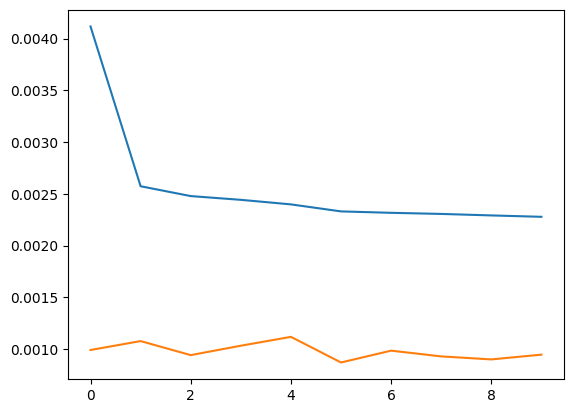

In [81]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [82]:
best_model = load_model("Predict30mins.keras")
y_pred = best_model.predict(X_test)

635/635 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step


In [83]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

In [90]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SMAPE function (already defined in your code)
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))  # Avoid division by zero

# MAPE function (already defined in your code)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10)))  # Avoid division by zero

# Ensure y_test and y_pred have consistent shapes
if len(y_test.shape) == 2:  # If y_test is already 2D
    y_test_adjusted = y_test
elif len(y_test.shape) == 3:  # If y_test is 3D (multi-step)
    y_test_adjusted = y_test[:, 0]  # Take the first step to match y_pred

# Flatten both arrays for metric calculations
y_test_flat = y_test_adjusted.flatten()
y_pred_flat = y_pred.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape_value = mape(y_test_flat, y_pred_flat)
print(f'MAPE: {mape_value:.4f}%')

smape_value = smape(y_test_flat, y_pred_flat)
print(f'SMAPE: {smape_value:.4f}%')

mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f'MAE: {mae:.4f}')

RMSE: 0.0391
MAPE: 10.3693%
SMAPE: 9.4615%
MAE: 0.0271


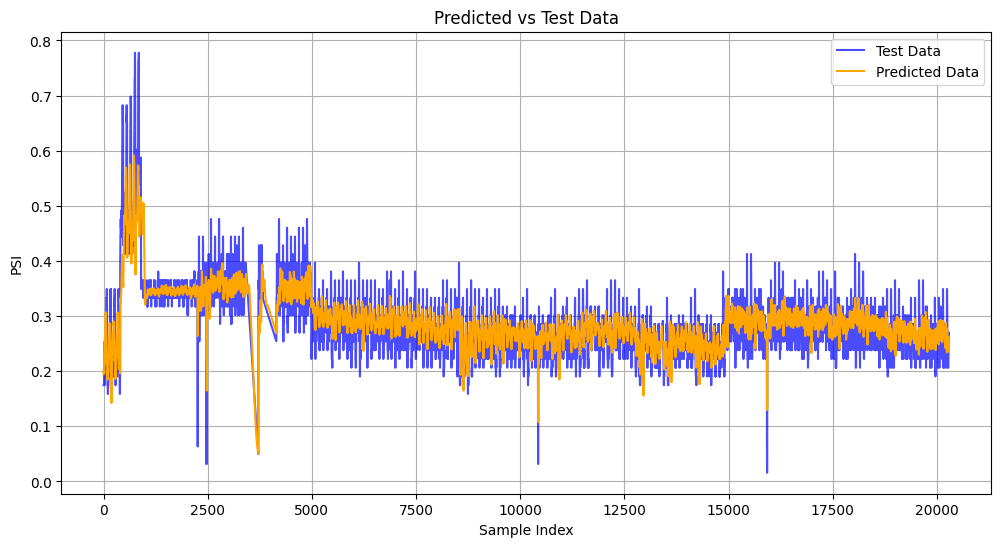

In [93]:
# Plot the test data and predictions
plt.figure(figsize=(12, 6))
plt.plot(test_indices, y_test_flat, label='Test Data', color='blue', alpha=0.7)
plt.plot(test_indices, y_pred_flat, label='Predicted Data', color='orange')

# Add labels, legend, and title
plt.xlabel('Sample Index')
plt.ylabel('PSI')
plt.title('Predicted vs Test Data')
plt.legend()
plt.grid()
plt.show()

In [85]:
print(y_test.shape)
print(y_pred.shape)

(20291, 30, 1)
(20291, 1)


In [39]:
import matplotlib.pyplot as plt

# Load the model
best_model = load_model("PredictOneHour.keras")

# Generate predictions
y_pred = best_model.predict(X_test)

635/635 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step
